# Первое задание по вычислительной математике. Жесткие системы ОДУ и их решения

In [2]:
# Подключаем заклинания
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
from scipy.integrate import solve_ivp
from scipy import sqrt
from spellbook import *
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

Вводим систему и начальные условия из задания

In [3]:
def f(t, y):
    return np.array([
        -1.71*y[0] + 0.43*y[1] + 8.23*y[2] + 0.0007,
        1.71*y[0] - 8.75*y[1],
        -10.03*y[2] + 0.43*y[3] + 0.035*y[4],
        8.32*y[1] + 1.71*y[2] - 1.12*y[3],
        -1.745*y[4] + 0.43*y[5] + 0.43*y[6],
        -280*y[5]*y[7] + 0.69*y[3] + 1.71*y[4] - 0.43*y[5] + 0.69*y[6],
        280*y[5]*y[7] - 1.87*y[6],
        -280*y[5]*y[7] + 1.87*y[6]
    ])

t0, te = 0, 421.8122
tol_newton = 1e-8
init = array([1, 0, 0, 0, 0, 0, 0, 0.0057])

## Часть 0. Эталонное решение
В качестве образца использован метод Гаусса

In [4]:
n_steps = 40000
gauss = Gauss(f, init, t0, te, n_steps, tol_newton)

In [5]:
gauss.solve()

100%|██████████| 40001/40001 [07:16<00:00, 91.55it/s] 


Визуализируем зависимость всех переменных от времени

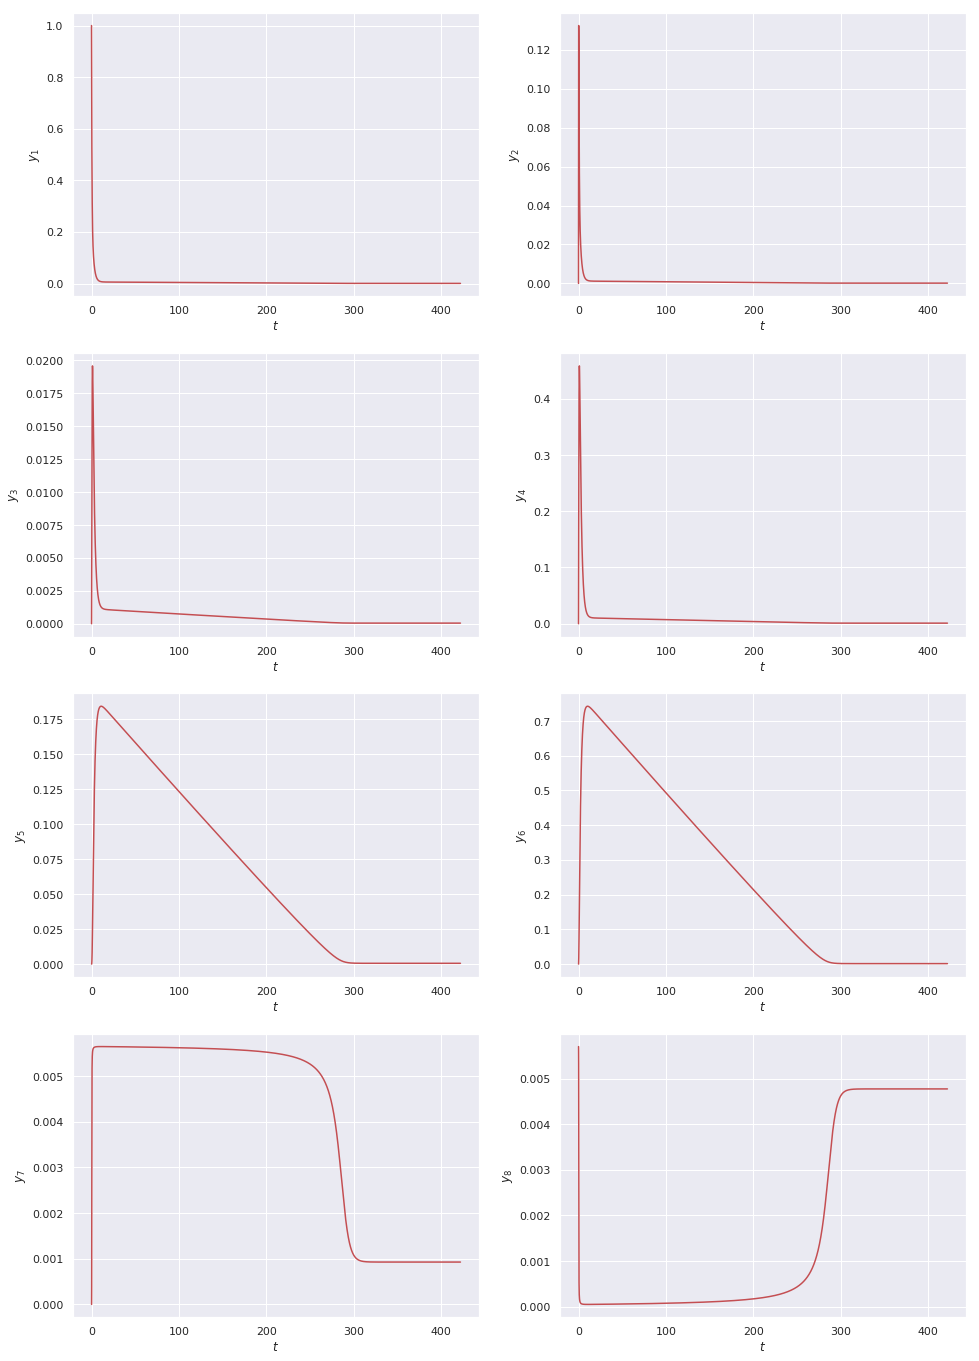

In [6]:
paragon = np.array(gauss.solution)
fig, axes = plt.subplots(4,2, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

## Часть 1. Неявные методы Рунге-Кутты

Имплементируем методы из задания

In [7]:
s = sqrt(2)
class SDIRK1(RungeImplicit):
    A = array([[0.5*(2+s), 0],
               [-s, 0.5*(2+s) ]])
    b = array([0.5, 0.5])
    c = array([0.5*(2+s), 0.5*(2-s)])

class SDIRK2(RungeImplicit):
    A = array([[0.5*(2-s), 0],
               [s, 0.5*(2-s) ]])
    b = array([0.5, 0.5])
    c = array([0.5*(2-s), 0.5*(2+s)])

q = sqrt(3)
class SDIRK3(RungeImplicit):
    A = array([[(1/6)*(3+q), 0],
               [(1/6)*(3-2*q), (1/6)*(3+q)]])
    b = array([0.5, 0.5])
    c = array([(1/6)*(3+q), (1/6)*(3-q)])

In [8]:
n_steps = 40000
sdirk1 = SDIRK1(f, init, t0, te, n_steps, tol_newton)
sdirk2 = SDIRK2(f, init, t0, te, n_steps, tol_newton)
sdirk3 = SDIRK3(f, init, t0, te, n_steps, tol_newton)

И получим решения системы

In [9]:
sdirk1.solve()

100%|██████████| 40001/40001 [06:58<00:00, 95.59it/s] 


In [10]:
sdirk2.solve()

100%|██████████| 40001/40001 [06:38<00:00, 100.45it/s]


In [11]:
sdirk3.solve()

100%|██████████| 40001/40001 [06:26<00:00, 103.60it/s]


## Часть 2. Формулы дифференцирования назад
Выполним все действия предыдущего пункта для формул дифференцирования назад

In [12]:
bdf_sol = solve_ivp(f, (t0, te), init.copy(), method='BDF', t_eval=np.linspace(t0, te, n_steps), params={'order': 2})
bdf_sol = np.vstack((bdf_sol.t, bdf_sol.y)).T

## Часть 3. Сравнение результатов

Для сравнения результатов с эталоном рассчитаем абсолютную ошибку по переменным $y_3$, $y_5$, $y_8$ и визуализируем её

In [13]:
solutions  = {'SDIRK1': array(sdirk1.solution), 'SDIRK2':array(sdirk2.solution), 'SDIRK3':array(sdirk3.solution), 'BDF':bdf_sol}

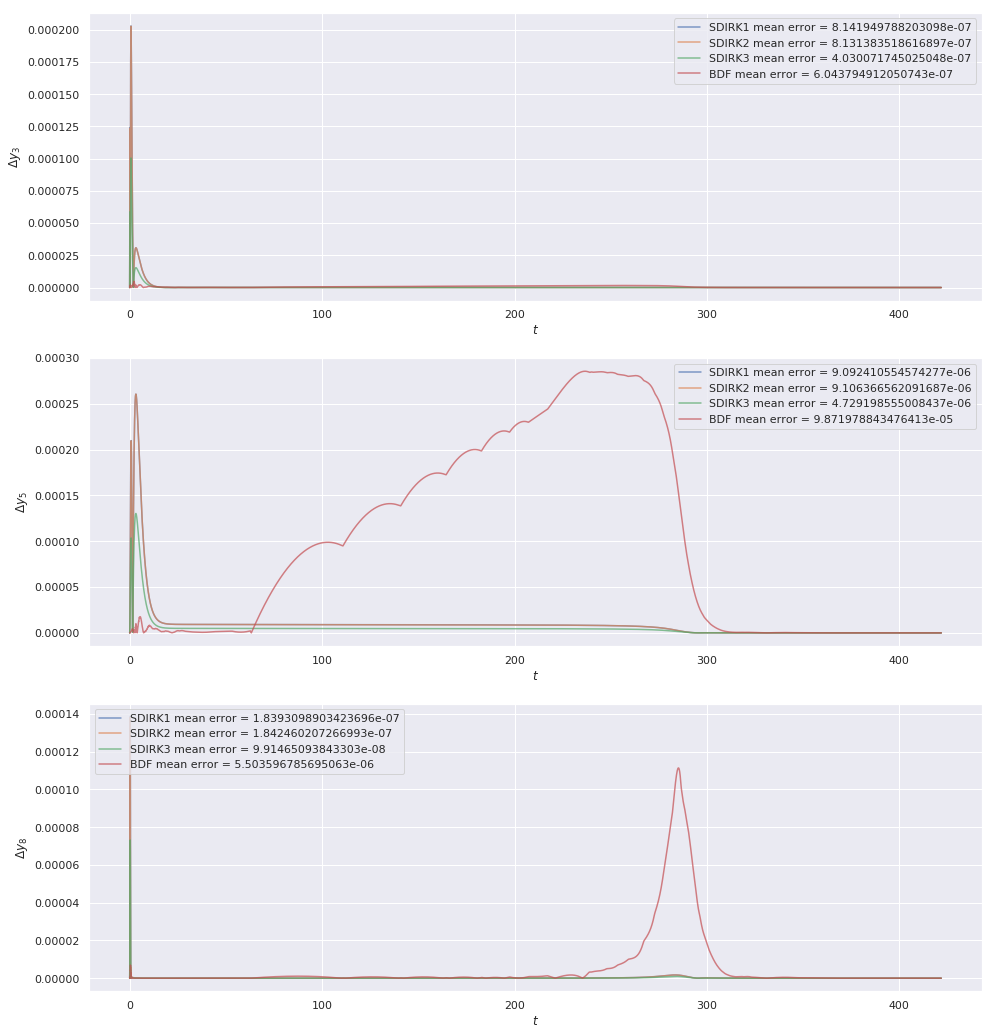

In [14]:
fig, axes = plt.subplots(3,1, figsize=(16, 18))
var = [3, 5, 8]
for i, ax in enumerate(axes.flatten()):
    for model in solutions:
        differ = np.abs(solutions[model][:, var[i]][:n_steps] - paragon[:, var[i]][:n_steps])
        ax.plot(paragon[:, 0][:n_steps], differ[:n_steps], label=model+' mean error = {}'.format(differ.mean()), alpha=0.7)
    ax.legend()
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Delta y_{'+str(var[i])+'}$')
plt.show()

Можно видеть, что среди исследованных методов наиболее высокое качество показал SDIRK3, который имеет третий порядок аппроксимации.

## Часть 4. Функции устойчивости использованных методов

In [15]:
import nodepy.linear_multistep_method as lm
bdf2=lm.backward_difference_formula(2)

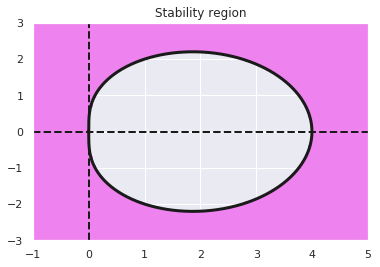

In [16]:
bdf2.plot_stability_region(N=100, color='violet', bounds=[-1, 5, -3, 3])
plt.show()

In [17]:
from nodepy import runge_kutta_method as rk

0.5*z*(-1.4142135623731*z/(-1.70710678118655*z + 1) + 1.0)/(-1.70710678118655*z + 1) + 0.5*z/(-1.70710678118655*z + 1) + 1

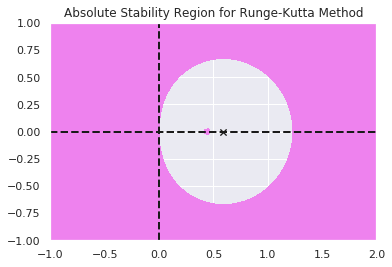

In [18]:
SD1=rk.RungeKuttaMethod(sdirk1.A, sdirk1.b)
SD1.plot_stability_region(N=100, color='violet', bounds=[-1, 2, -1, 1])
SD1.stability_function_unexpanded()

0.5*z*(1.4142135623731*z/(-0.292893218813452*z + 1) + 1.0)/(-0.292893218813452*z + 1) + 0.5*z/(-0.292893218813452*z + 1) + 1

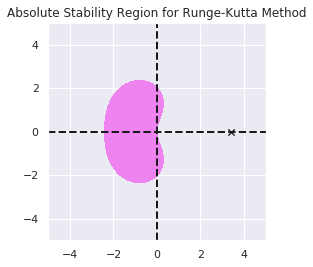

In [19]:
SD2=rk.RungeKuttaMethod(sdirk2.A, sdirk2.b)
SD2.plot_stability_region(N=100, color='violet', bounds=[-5, 5, -5, 5])
SD2.stability_function_unexpanded()

0.5*z*(-0.0773502691896257*z/(-0.788675134594813*z + 1) + 1.0)/(-0.788675134594813*z + 1) + 0.5*z/(-0.788675134594813*z + 1) + 1

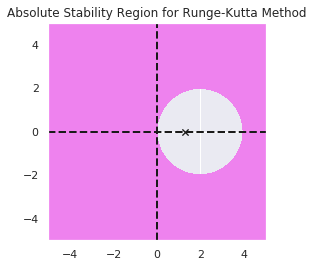

In [20]:
SD3=rk.RungeKuttaMethod(sdirk3.A, sdirk3.b)
SD3.plot_stability_region(N=100, color='violet', bounds=[-5, 5, -5, 5])
SD3.stability_function_unexpanded()